<a href="https://colab.research.google.com/github/Hung369/Sentiment-Analysis/blob/main/fine_tuning_sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install transformers datasets
!pip install torchinfo

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.3/527.3 kB 17.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 56.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 17.4 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 17.0.0 which is incompatible.
ibis-framework 8.0.0 requires pyarrow<16,>=2, but you have pyarrow 17.0.0 which is incompatible.


In [ ]:
from datasets import load_dataset, load_metric, Dataset
from transformers import AutoTokenizer, TrainingArguments, AutoModelForSequenceClassification, pipeline, AutoModelForSequenceClassification, AutoConfig, EarlyStoppingCallback
import torch
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from transformers import Trainer, TrainingArguments
from torchinfo import summary
from pprint import pprint
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
dataset = load_dataset("amazon_polarity")
print(dataset)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/3600000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/400000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['label', 'title', 'content'],
        num_rows: 3600000
    })
    test: Dataset({
        features: ['label', 'title', 'content'],
        num_rows: 400000
    })
})


In [ ]:
print(dataset['train'])
print(dataset['train'][0])

Dataset({
    features: ['label', 'title', 'content'],
    num_rows: 3600000
})
{'label': 1, 'title': 'Stuning even for the non-gamer', 'content': 'This sound track was beautiful! It paints the senery in your mind so well I would recomend it even to people who hate vid. game music! I have played the game Chrono Cross but out of all of the games I have ever played it has the best music! It backs away from crude keyboarding and takes a fresher step with grate guitars and soulful orchestras. It would impress anyone who cares to listen! ^_^'}


In [ ]:
print(dataset['train'].features)
print(dataset['train'].column_names)

{'label': ClassLabel(names=['negative', 'positive'], id=None), 'title': Value(dtype='string', id=None), 'content': Value(dtype='string', id=None)}
['label', 'title', 'content']


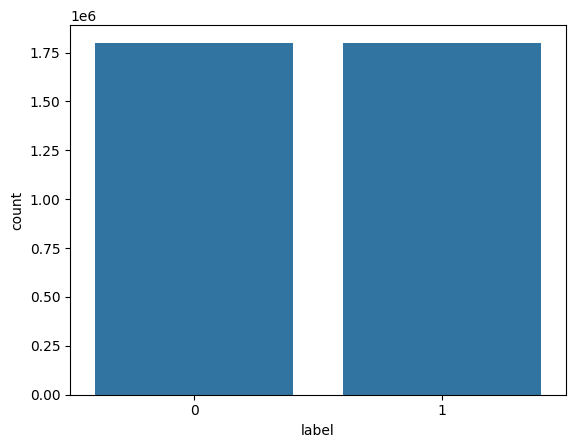

In [ ]:
sns.countplot(x=dataset['train']['label'])
plt.xlabel('label')
plt.show()

In [ ]:
train_dataset, test_dataset = dataset['train'], dataset['test']
target_map = {'positive': 1, 'negative': 0}

In [ ]:
# download model and tokenizer from model hub
model = AutoModelForSequenceClassification.from_pretrained('distilbert-base-cased')
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-cased')

config.json:   0%|          | 0.00/465 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/263M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

In [ ]:
def tokenize(batch):
    return tokenizer(batch['content'], padding='max_length', truncation=True)

# Tokenize
train_dataset = train_dataset.map(tokenize, batched=True, batch_size=100000)
test_dataset = test_dataset.map(tokenize, batched=True, batch_size=100000)

# Set the format to PyTorch
train_dataset = train_dataset.rename_column("label", "labels")
train_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])
test_dataset = test_dataset.rename_column("label", "labels")
test_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])

Map:   0%|          | 0/3600000 [00:00<?, ? examples/s]

Map:   0%|          | 0/400000 [00:00<?, ? examples/s]

In [ ]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f_1, _ = precision_recall_fscore_support(labels, preds, average="binary")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f_1, "precision": precision, "recall": recall}

In [ ]:
# define training args
training_args = TrainingArguments(
    output_dir="/content/drive/MyDrive/result",
    num_train_epochs=1,
    per_device_train_batch_size=64,
    per_device_eval_batch_size=64,
    warmup_steps=500,
    weight_decay=0.01,
    eval_strategy="steps",
    save_strategy="steps",
    save_steps=500,
    eval_steps=500,
    logging_steps=500,
    load_best_model_at_end=True,
    learning_rate=5e-5
)

# create Trainer instance
trainer = Trainer(
    model=model,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

# train model
trainer.train()

# evaluate model
eval_result = trainer.evaluate(eval_dataset=test_dataset)

Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
500,0.341000,0.220363,0.913770,0.913667,0.914761,0.912575
1000,0.221500,0.197121,0.923242,0.924129,0.913579,0.934925
1500,0.195700,0.182010,0.930432,0.930684,0.927328,0.934065
2000,0.186000,0.191851,0.933355,0.933584,0.930385,0.936805
2500,0.180200,0.170467,0.936230,0.936214,0.936448,0.935980
3000,0.173800,0.164044,0.938702,0.938047,0.948188,0.928120
3500,0.162800,0.159244,0.939377,0.938492,0.952404,0.924980
4000,0.160600,0.165164,0.937462,0.938572,0.922206,0.955530
4500,0.163800,0.159095,0.939573,0.940331,0.928673,0.952285
5000,0.159800,0.153928,0.942612,0.942427,0.945488,0.939385


Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
500,0.341000,0.220363,0.913770,0.913667,0.914761,0.912575
1000,0.221500,0.197121,0.923242,0.924129,0.913579,0.934925
1500,0.195700,0.182010,0.930432,0.930684,0.927328,0.934065
2000,0.186000,0.191851,0.933355,0.933584,0.930385,0.936805
2500,0.180200,0.170467,0.936230,0.936214,0.936448,0.935980
3000,0.173800,0.164044,0.938702,0.938047,0.948188,0.928120
3500,0.162800,0.159244,0.939377,0.938492,0.952404,0.924980
4000,0.160600,0.165164,0.937462,0.938572,0.922206,0.955530
4500,0.163800,0.159095,0.939573,0.940331,0.928673,0.952285
5000,0.159800,0.153928,0.942612,0.942427,0.945488,0.939385


In [ ]:
#  trainer.save_model("/content/drive/MyDrive/result/model")

# load model last save checkpoint
model = AutoModelForSequenceClassification.from_pretrained("/content/drive/MyDrive/result/checkpoint-14000")
tokenizer = AutoTokenizer.from_pretrained("/content/drive/MyDrive/result/checkpoint-14000")

In [ ]:
reviews = [
    {'title': 'Exceeded Expectations', 'content': 'This product is great! It really exceeded my expectations.'},
    {'title': 'Terrible Quality', 'content': 'Terrible quality. I want a refund.'},
    {'title': 'Mediocre Experience', 'content': 'The item was okay, not as described but still usable.'},
    {'title': 'Perfect Purchase', 'content': 'I love it! Works perfectly and arrived on time.'},
    {'title': 'Complete Disappointment', 'content': 'Completely disappointed with this purchase. Not recommended.'}
]
reviews = Dataset.from_list(reviews)

# Tokenize and prepare the input
inputs = reviews.map(tokenize, batched=True)
inputs.set_format('torch', columns=['input_ids', 'attention_mask'])

# Make predictions
with torch.no_grad():
    outputs = model(input_ids=input_ids, attention_mask=attention_mask)
    predictions = torch.argmax(outputs.logits, dim=-1)

# Decode predictions
predicted_labels = ["Positive" if pred == 1 else "Negative" for pred in predictions]
for review, label in zip(reviews, predicted_labels):
    print(f'Review: "{review}" \nSentiment: {label}\n')


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Review: "{'title': 'Exceeded Expectations', 'content': 'This product is great! It really exceeded my expectations.'}" 
Sentiment: Positive

Review: "{'title': 'Terrible Quality', 'content': 'Terrible quality. I want a refund.'}" 
Sentiment: Negative

Review: "{'title': 'Mediocre Experience', 'content': 'The item was okay, not as described but still usable.'}" 
Sentiment: Negative

Review: "{'title': 'Perfect Purchase', 'content': 'I love it! Works perfectly and arrived on time.'}" 
Sentiment: Positive

Review: "{'title': 'Complete Disappointment', 'content': 'Completely disappointed with this purchase. Not recommended.'}" 
Sentiment: Negative

